In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Alex Mallen (atmallen@uw.edu)
"""

import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import time
import xarray as xr
import datetime as dt

from torch import optim
import torch.nn as nn
from torch.fft import fftn, fftfreq

from dpk import model_objs, koopman_probabilistic

seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

[ Using Seed :  633  ]


so we need to fit everything in memory.

- we have to calculate the losses for every pair of (possible output, observation in batch)
- this takes a tensor of shape (batch_size, K^3, xdim) if we want backpropagation to run fast  (32*24 * 10**3 * 1038240 => 3189 GB)
- this can be divided into smaller chunks and calculated in a for loop which proportionally slows things down (space /x means time *x)
- we also have to store all intermediate values in the NN evaluation, of which the "batch size" is K^3, so however much memory is taken by applying the NN on one datapoint 


In [6]:
class FlowNet(model_objs.ModelObject):
    
    def __init__(self, xdim, num_freqs, n1=13, n2=24, n_chan=4, num_covariates=0):
        assert num_covariates == 0
        # assert xdim == 1038240

        if type(num_freqs) is int:
            num_freqs = [num_freqs]
        super(FlowNet, self).__init__(num_freqs, num_covariates)
        self.n1 = n1
        self.n2 = n2
        
        self.l1 = nn.Linear(2*num_freqs[0], 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, n1*n2)
        self.c1 = nn.Conv2d(1, n_chan, 3)
        
        self.block1 = nn.Sequential(nn.ConvTranspose2d(n_chan, n_chan, 3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        # self.block2 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh())
        
        # self.block3 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan, 3, stride = 2),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh())
        
        # self.block4 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh())
        
        # self.block5 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh())
        
        self.block6 = nn.Sequential(nn.ConvTranspose2d(n_chan,8,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 1, 3, padding = 1))
        
        
    def decode(self, w):
        
        x = nn.Tanh()(self.l1(w))
        x = nn.Tanh()(self.l2(x))
        x = nn.Tanh()(self.l3(x)).reshape((-1,1,self.n1,self.n2))
        x = nn.Tanh()(self.c1(x))
        
        x = self.block1(x)
        # x = self.block2(x)
        # x = self.block3(x)
        # x = self.block4(x)
        # x = self.block5(x)
        x = self.block6(x)
        x = x[:, ..., 1:-2, 4:-4]
        x = x.flatten(start_dim=-2)
        
        return x

    def forward(self, w, data, training_mask=None):
        assert training_mask is None, "training mask not supported"
        xhat = self.decode(w)
        losses = (data.type(w.type()) - xhat) ** 2
        avg = torch.mean(losses, dim=-1)
        return avg
        

In [7]:
periods = [24, 24 * 7, 24 * 365.24]
omegas = [2 * np.pi / p for p in periods]
omega_dim = len(omegas)
xdim = 1836 # 1038240
# define a model
n1 = 11
n2 = 16
wd = 1e-3
lrt = 1e-3
model = FlowNet(xdim=xdim, num_freqs=omega_dim, n1=n1, n2=n2)
k = koopman_probabilistic.KoopmanProb(model, batch_size=32, device="cpu")
k.init_periods(periods)
num_params = 1
num_nn_params = sum(p.numel() for p in model.parameters())
num_nn_params

81757

In [8]:
# estimates by looking at various samples of the data 
loc = -25.0
scale = 3.0  # variance attempts to account for both inter and intra sample variance

In [10]:
import pandas as pd

num_epochs = 10
start_time = time.time()
all_dates = pd.date_range(dt.datetime(2018, 1, 1), dt.datetime(2020, 1, 1), freq="D", closed="left")
T = len(all_dates) * 24
batch_size = T  # number of timesteps to load at once 

x = torch.empty((batch_size, xdim))  # allocate memory once

# train the model
for itr in range(T // batch_size):
    print("\n\n\n")
    batches = np.random.permutation(len(all_dates))
    shuffled_dates = all_dates[batches]
    t_idxs = []
    # load batch from disk
    batch = shuffled_dates[itr * (batch_size // 24):(itr + 1) * (batch_size // 24)]
    for i, current_date in enumerate(batch):
        t_idxs.extend([j + batches[i] * 24 for j in range(24)])  # append 24d, 24d+1, 24d+2,..., 24d+23
        # xrdata = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
        # darr = xrdata.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
        darr = np.load(r"D:atmo-chem/data/northeast/NO2_" + str(current_date)[:10] + ".npy")

        flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
        x_day = torch.from_numpy((np.log(flattened) - loc) / scale)
        x[i * 24:(i + 1) * 24, :] = x_day.T
    t_idxs = np.asarray(t_idxs)
    
    k.fit(x, iterations=num_epochs, cutoff=0, weight_decay=wd, lr_theta=lrt, lr_omega=0, verbose=True)





Iteration  0
tensor([  24.0000,  168.0000, 8765.7598])


c:\Users\ATMal\Documents\2021fall\NASA-GEOS\.venv\lib\site-packages\dpk\koopman_probabilistic.py:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xt_t = torch.tensor(xt[batches[i], :], device=self.device)


Setting periods to tensor([  24.0000,  168.0000, 8765.7598], grad_fn=<MulBackward0>)
Loss:  0.2370904
Iteration  1
tensor([  24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598], grad_fn=<MulBackward0>)
Loss:  0.2369081
Iteration  2
tensor([  24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598], grad_fn=<MulBackward0>)
Loss:  0.23671593
Iteration  3
tensor([  24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598], grad_fn=<MulBackward0>)
Loss:  0.23647712
Iteration  4
tensor([  24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598], grad_fn=<MulBackward0>)
Loss:  0.2361987
Iteration  5
tensor([  24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598], grad_fn=<MulBackward0>)
Loss:  0.23597151
Iteration  6
tensor([  24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7

In [12]:
current_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 3, 15)
H = ((end_date - current_date).days) * 24

omega_ts = torch.stack([torch.arange(T + H) * omega for omega in omegas]).T
forecast_inpts = torch.cat([torch.cos(omega_ts)] * 1 + [torch.sin(omega_ts)] * 1, -1)  # todo: generalize to more omegas
params = model.output(forecast_inpts)
mean_hat = np.array(params) * scale + loc

In [13]:
mean_hat.shape

(19296, 1, 1836)

In [15]:
mean_hat[0]

array([[-21.56441 , -21.566793, -21.563206, ..., -20.833458, -20.837616,
        -20.838627]], dtype=float32)

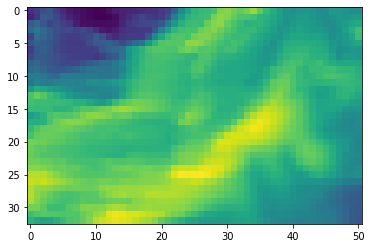

In [19]:
plt.imshow(x[10000, :].reshape((36, 51))[2:-1, :])

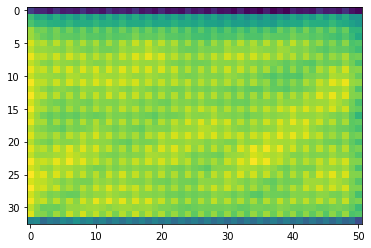

In [17]:
plt.imshow(mean_hat[10000, 0, :].reshape((36, 51))[2:-1, :])

In [27]:
param_str = f"ConvNetNLL_{n1}_{n2}_{batch_size}_{num_epochs}_{seed}_{wd}_{lrt}"
# np.save(f"forecasts/params_{param_str}.npy", np.array(params))
torch.save(model.state_dict(), f"forecasts/model_{param_str}.pt")